In [ ]:
%matplotlib inline

# Importing libraries
import os
import pickle
import warnings
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import keras
import matplotlib.pyplot as plt
import json
import seaborn as sns

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from datetime import datetime
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, GaussianNoise, concatenate, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import get_file, to_categorical, plot_model, print_summary
from keras import backend as K
from keras import regularizers
from keras import losses
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from joblib import dump, load
from google.colab import drive

Using TensorFlow backend.


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# If using google colab
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# URL = ""

# data_dir = get_file(
#     'Dataset',
#     URL,
#     extract=True)

!cp "./drive/My Drive/Dataset/xPLNet.zip" "/content"
!unzip /content/xPLNet.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/Training Samples/8/18758.png  
 extracting: DATASET/Training Samples/8/18764.png  
 extracting: DATASET/Training Samples/8/18780.png  
 extracting: DATASET/Training Samples/8/18787.png  
 extracting: DATASET/Training Samples/8/18809.png  
 extracting: DATASET/Training Samples/8/18814.png  
 extracting: DATASET/Training Samples/8/18840.png  
 extracting: DATASET/Training Samples/8/18853.png  
 extracting: DATASET/Training Samples/8/18863.png  
 extracting: DATASET/Training Samples/8/18875.png  
 extracting: DATASET/Training Samples/8/18876.png  
 extracting: DATASET/Training Samples/8/1889.png  
 extracting: DATASET/Training Samples/8/18895.png  
 extracting: DATASET/Training Samples/8/18909.png  
 extracting: DATASET/Training Samples/8/18910.png  
 extracting: DATASET/Training Samples/8/18924.png  
 extracting: DATASET/Training Samples/8/18936.png  
 extracting: DATASET/Training Samples/8/18937.png  
 extracting: D

In [ ]:
data_dir = "/content/DATASET"
data_dir

'/content/DATASET'

In [ ]:
!nvidia-smi

Tue Feb 25 02:23:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
date_time_dir = f"training-{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}"

# Create directories if not exists
if not os.path.exists("./drive/My Drive/checkpoint/" + date_time_dir):
    os.makedirs("./drive/My Drive/checkpoint/" + date_time_dir)

if not os.path.exists("./drive/My Drive/history"):
    os.makedirs("./drive/My Drive/history")

In [ ]:
# Model Architecture (Functional)

def conmax(layer: keras.layers = None, filters: int = None, names: list = None) -> keras.layers:
  x = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same", name=names[0])(layer)
  x = LeakyReLU(alpha=0.15, name=names[1])(x)
  
  x = MaxPooling2D(pool_size=(2, 2), padding="valid", name=names[2])(x)
  x = BatchNormalization(name=names[4])(x)
  
  return x

def fc_layers(layer: keras.layers = None, units: int = None, names: list = None) -> keras.layers:
  x = Dense(units=units, name=names[0])(layer)
  x = LeakyReLU(alpha=0.1, name=names[1])(x)
  x = Dropout(rate=0.5, name=names[2])(x)

  return x

inputs = Input(shape=(64, 64, 3), name="Input_1")

x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), name="Conv2D_1")(inputs)

x = LeakyReLU(alpha=0.15, name="Leaky_ReLU_1")(x)

x = BatchNormalization(name="Batch_Normalization_1")(x)

x = conmax(layer=x, filters=32, names=["Conv2D_2", "Leaky_ReLU_2", "Max_Pooling2D_1", "Dropout_1", "Batch_Normalization_2"])

x = conmax(layer=x, filters=32, names=["Conv2D_3", "Leaky_ReLU_3", "Max_Pooling2D_2", "Dropout_2", "Batch_Normalization_3"])

x = conmax(layer=x, filters=32, names=["Conv2D_4", "Leaky_ReLU_4", "Max_Pooling2D_3", "Dropout_3", "Batch_Normalization_4"])

x = conmax(layer=x, filters=32, names=["Conv2D_5", "Leaky_ReLU_5", "Max_Pooling2D_4", "Dropout_4", "Batch_Normalization_5"])

x = Flatten(name="Flatten_1")(x)

x = Dropout(rate=0.5, name="Dropout_5")(x)

x = fc_layers(layer=x, units=256, names=["Dense_1", "Leaky_ReLU_6", "Dropout_6"])

x = fc_layers(layer=x, units=128, names=["Dense_2", "Leaky_ReLU_7", "Dropout_7"])

output = Dense(units=9, name="Dense_3", kernel_regularizer=regularizers.l1(0.01))(x)

output = Activation("linear", name="Activation_1")(output)

model = Model(inputs=inputs, outputs=output)

model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)     (None, 62, 62, 32)        0         
_________________________________________________________________
Batch_Normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
Leaky_ReLU_2 (LeakyReLU)     (None, 62, 62, 32)        0         
____

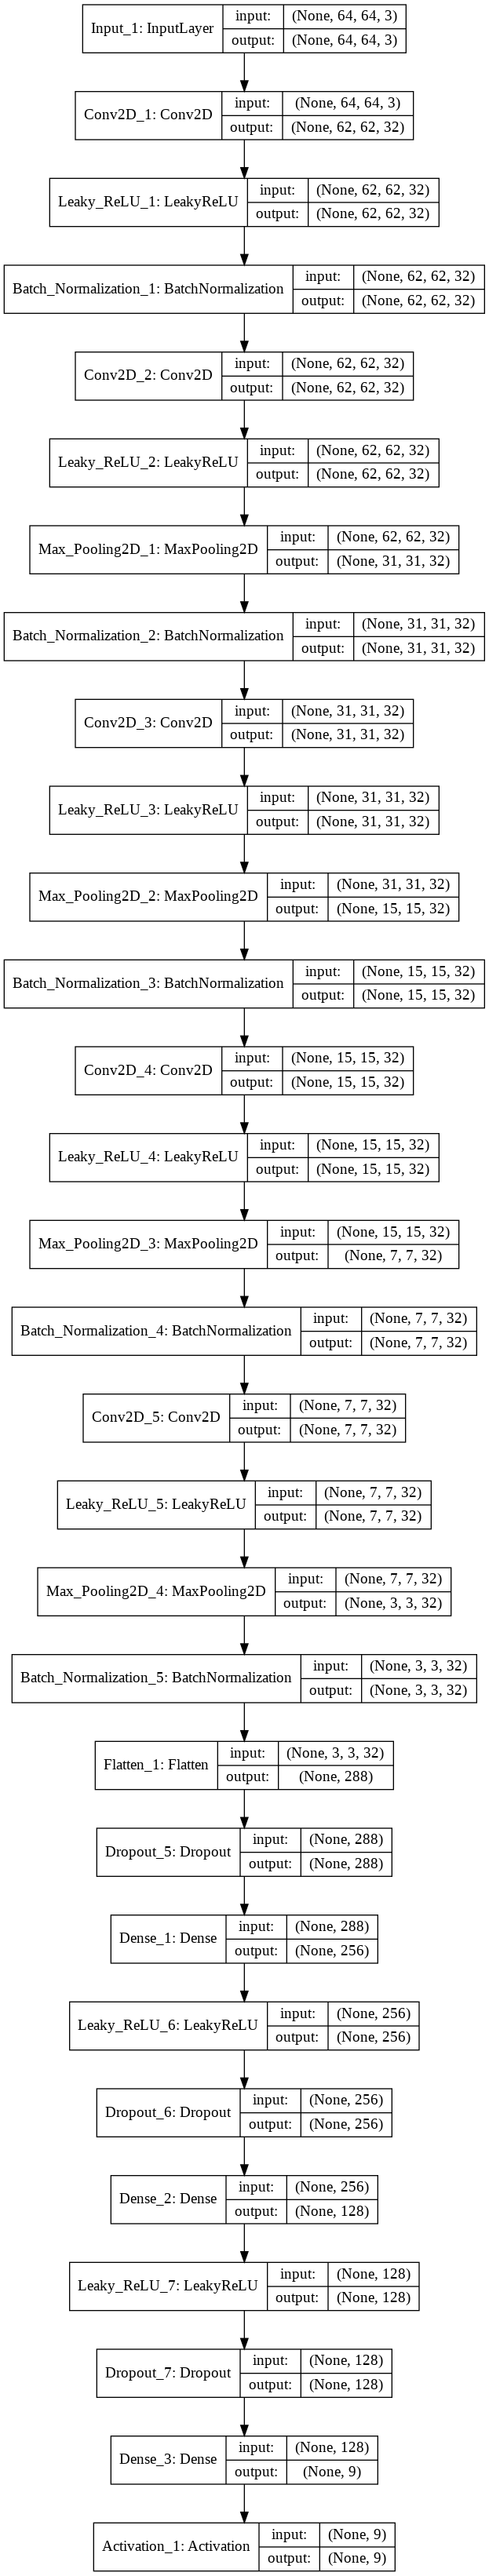

In [ ]:
plot_model(model, to_file="model.png", show_shapes=True, rankdir="TB", expand_nested=False, dpi=96)

In [ ]:
with h5py.File("./drive/My Drive/Dataset/soybean_leaf.h5", 'r') as hf:
  x_train = np.asarray(hf["Training Samples"])
  x_test = np.asarray(hf["Test Samples"])

In [ ]:
labels = [i for i in range(0, 9, 1)]
train_dir = data_dir + "/Training Samples"

for i in range(0, 9, 1):
    print(f"{labels[i]} {len(os.listdir(os.path.join(train_dir, str(i))))} images")

train = []

for index, label in enumerate(labels):
    for file in os.listdir(os.path.join(train_dir, str(label))):
        train.append(['../root/.keras/datasets/DATASET/Training Samples/{}/{}'.format(label, file), index, label])
        
train = pd.DataFrame(train, columns=['file', 'index', 'label'])

print('Training Data: ',train.shape)

0 5953 images
1 5897 images
2 5934 images
3 11850 images
4 5918 images
5 5937 images
6 5872 images
7 5906 images
8 5917 images
Training Data:  (59184, 3)


In [ ]:
y_labels = train['index']
y_labels = to_categorical(y_labels, num_classes = len(labels))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_labels, 
                                                  test_size=0.3, 
                                                  random_state=12)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(41428, 64, 64, 3)
(17756, 64, 64, 3)
(6576, 64, 64, 3)


In [ ]:
# Compiling Model
optimizer = Adam(lr=0.0001, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=None, 
                 decay=0.0, 
                 amsgrad=False)

model.compile(optimizer=optimizer, loss=losses.categorical_hinge, metrics=["accuracy"])

In [ ]:
# Callbacks

# Save Trained Model for each Epoch (Best Only)
file_path = "./drive/My Drive/checkpoint/" + date_time_dir + "/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
file_path_weights_only = "./drive/My Drive/checkpoint/" + date_time_dir + "/weights-only-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_acc', verbose=1, save_best_only=True)
checkpoint_weights_only = ModelCheckpoint(filepath=file_path_weights_only, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)

# Log the output after fitting
csv_logger = CSVLogger(f'./drive/My Drive/Dataset/training_{datetime.now().strftime("%A-%m-%d-%Y-%H-%M-%S")}.csv', separator=',', append=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

In [ ]:
# Fitting training and test images into the model
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=64,
        epochs=150,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint, checkpoint_weights_only, csv_logger],
        verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 41428 samples, validate on 17756 samples
Epoch 1/150


41428/41428 [==============================] - 33s 790us/step - loss: 3.1756 - acc: 0.2688 - val_loss: 1.9402 - val_acc: 0.4958

Epoch 00001: val_acc improved from -inf to 0.49583, saving model to ./drive/My Drive/checkpoint/training-Sunday-01-19-2020-00-30-30/weights-improvement-01-0.50.hdf5

Epoch 00001: val_acc improved from -inf to 0.49583, saving model to ./drive/My Drive/checkpoint/training-Sunday-01-19-2020-00-30-30/weights-only-improvement-01-0.50.hdf5
Epoch 2/150
41428/41428 [==============================] - 18s 427us/step - loss: 2.1618 - acc: 0.3691 - val_loss: 1.6885 - val_acc: 0.5140

Epoch 00002: val_acc improved from 0.49583 to 0.51402, saving model to ./drive/My Drive/checkpoint/training-Sunday-01-19-2020-00-30-30/weights-improvement-02-0.51.hdf5

Epoch 00002: val_acc improved from 0.49583 to 0.51402, saving mod

In [ ]:
model.save(f"./drive/My Drive/Dataset/model_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

In [ ]:
model.save_weights(f"./drive/My Drive/Dataset/model_weights_only_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

In [ ]:
# Save Model History
file_path_history = f'./drive/My Drive/history/train-history-{datetime.now().strftime("%A-%m-%d-%Y-%H-%M-%S")}'
with open(file_path_history, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
model_json = model.to_json()

with open(f"./drive/My Drive/Dataset/model_json_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}.json", "w") as json_file:
    json.dump(model_json, json_file)

In [ ]:
with open("/content/drive/My Drive/history/train-history-Sunday-09-01-2019-12-36-52", "rb") as file_pi:
  history = pickle.load(file_pi)

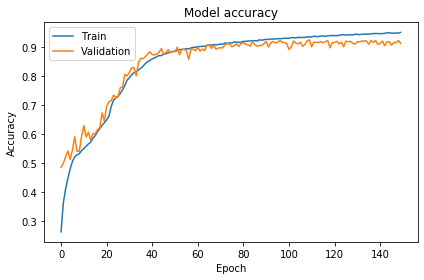

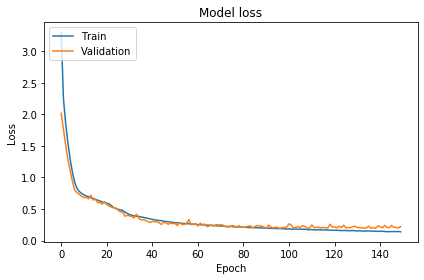

In [ ]:
# Plot training & validation accuracy values
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig("model_accuracy.png")
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig("model_loss.png")
plt.show()

In [ ]:
model = load_model("/content/drive/My Drive/Dataset/model_Sunday-09-01-2019-07-40-38")

In [ ]:
with open("/content/drive/My Drive/Dataset/model_json_Tuesday-08-27-2019-02-54-44.json", 'r') as json_file:
  json_content = json.load(json_file)
  model = model_from_json(json_content)

In [ ]:
model.load_weights("/content/drive/My Drive/Dataset/model_weights_only_Monday-08-26-2019-06-52-12")
model.compile(optimizer=Adam(lr=0.001), loss=losses.categorical_crossentropy, metrics=["accuracy"])

In [ ]:
pred_labels = np.argmax(model.predict(x_test), axis=1)

In [ ]:
labels = [i for i in range(0, 9, 1)]
test_dir = data_dir + "/Test Samples"

test = []
for index, label in enumerate(labels):
  for file in os.listdir(os.path.join(test_dir, str(label))):
      test.append(['../root/.keras/datasets/DATASET/Test Samples/{}/{}'.format(label, file), index])

test = pd.DataFrame(test, columns=['file', 'index'])

In [ ]:
y_test_labels = test['index']
y_test_labels = to_categorical(y_test_labels, num_classes = len(labels))

In [ ]:
model.evaluate(x_test, y_test_labels)

6576/6576 [==============================] - 3s 382us/step


[0.12431054839493341, 0.9568126520681265]

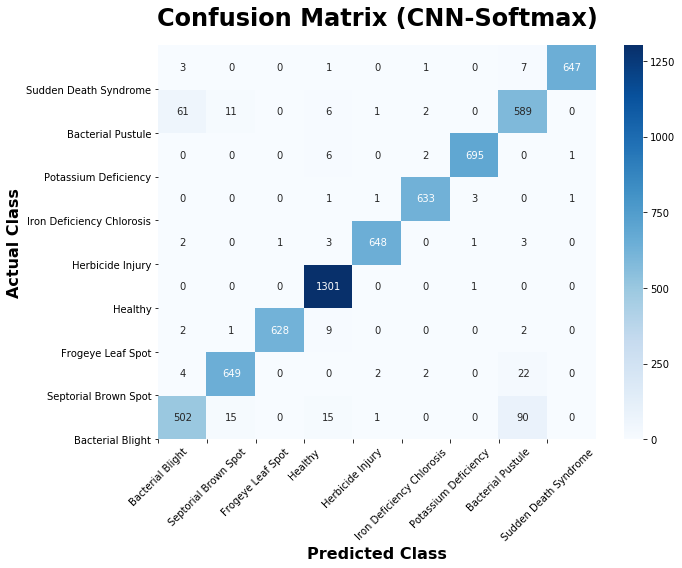

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-Softmax)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix.png")
plt.show()

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       623
           1       0.96      0.96      0.96       679
           2       1.00      0.98      0.99       642
           3       0.97      1.00      0.98      1302
           4       0.99      0.98      0.99       658
           5       0.99      0.99      0.99       639
           6       0.99      0.99      0.99       704
           7       0.83      0.88      0.85       670
           8       1.00      0.98      0.99       659

    accuracy                           0.96      6576
   macro avg       0.96      0.95      0.95      6576
weighted avg       0.96      0.96      0.96      6576



In [ ]:
test_image = np.expand_dims(x_test[400], axis=0)
prediction = model.predict(test_image)
np.argmax(prediction, axis=1)

array([0])

In [ ]:
model_new = Model(inputs=model.input, outputs=model.get_layer("Flatten_1").output)

In [ ]:
model_new.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)     (None, 62, 62, 64)        0         
_________________________________________________________________
Batch_Normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
Leaky_ReLU_2 (LeakyReLU)     (None, 62, 62, 64)        0         
_________________________________________________________________
Max_Pooling2D_1 (MaxPooling2 (None, 31, 31, 64)        0   

In [ ]:
feat_train = model_new.predict(x_train)

feat_val = model_new.predict(x_val)

feat_test = model_new.predict(x_test)

In [ ]:
feat_train_val = np.concatenate((feat_train, feat_val))
y_train_val = np.concatenate((y_train, y_val))

In [ ]:
%%time

svm_linear = LinearSVC()

# Grid Search
# Parameter Grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
 
# Make grid search classifier
svm_linear_grid = GridSearchCV(svm_linear, param_grid, n_jobs=-1, cv=10, verbose=1)
 
# Train the classifier
svm_linear_grid.fit(feat_train_val, np.argmax(y_train_val, axis=1))

print("Fitting done!")

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.6min finished


Fitting done!
CPU times: user 13 s, sys: 1.71 s, total: 14.7 s
Wall time: 28min 47s


In [ ]:
print("Best Accuracy:\n", svm_linear_grid.best_score_)
print("Best Parameters:\n", svm_linear_grid.best_params_)
print("Best Estimators:\n", svm_linear_grid.best_estimator_)

Best Accuracy:
 0.98202149829274
Best Parameters:
 {'C': 0.01}
Best Estimators:
 LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [ ]:
dump(svm_linear_grid, f"./drive/My Drive/Dataset/trained_model_svm_linear_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

['./drive/My Drive/Dataset/trained_model_svm_linear_Sunday-01-19-2020-01-44-10']

In [ ]:
svm_linear_grid.score(feat_train_val, np.argmax(y_train_val, axis=1))

0.9862969721546364

In [ ]:
svm_linear_grid.score(feat_test, np.argmax(y_test_labels, axis=1))

0.9565085158150851

In [ ]:
svm_linear_grid = load("/content/drive/My Drive/Dataset/trained_model_svm_linear_Sunday-01-19-2020-01-44-10")

In [ ]:
pred_labels = svm_linear_grid.predict(feat_test)

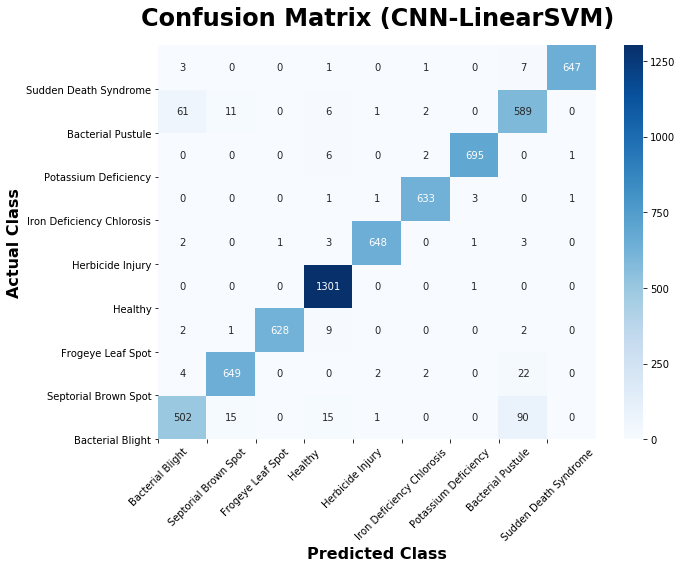

In [ ]:
confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-LinearSVM)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_2.png")
plt.show()

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       623
           1       0.95      0.96      0.95       679
           2       0.99      0.99      0.99       642
           3       0.99      1.00      0.99      1302
           4       0.98      0.99      0.98       658
           5       0.98      0.99      0.99       639
           6       1.00      0.99      0.99       704
           7       0.85      0.82      0.84       670
           8       0.99      0.99      0.99       659

    accuracy                           0.96      6576
   macro avg       0.95      0.95      0.95      6576
weighted avg       0.96      0.96      0.96      6576



In [ ]:
%%time
svm_rbf = SVC(kernel="rbf")

# Train the classifier
svm_rbf.fit(feat_train_val, np.argmax(y_train_val, axis=1))

print("Fitting done!")

Fitting done!
CPU times: user 6min 57s, sys: 0 ns, total: 6min 57s
Wall time: 6min 57s


In [ ]:
from joblib import dump

dump(svm_rbf, f"./drive/My Drive/Dataset/trained_model_svm_rbf_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

['./drive/My Drive/Dataset/trained_model_svm_rbf_Sunday-01-19-2020-01-57-43']

In [ ]:
# svm_rbf_grid.score(feat_train, np.argmax(y_train, axis=1))
svm_rbf.score(feat_train_val, np.argmax(y_train_val, axis=1))

0.9910279805352799

In [ ]:
# svm_rbf_grid.score(feat_test, np.argmax(y_test_labels, axis=1))
svm_rbf.score(feat_test, np.argmax(y_test_labels, axis=1))

0.962287104622871

In [ ]:
svm_rbf = load("/content/drive/My Drive/Dataset/trained_model_svm_rbf_Sunday-01-19-2020-01-57-43")

In [ ]:
test_img = x_test[3000]

In [ ]:
%%time

prediction = svm_rbf.predict(model_new.predict(test_img.reshape((1, 64, 64, 3))).reshape((1, -1)))

CPU times: user 30.2 ms, sys: 0 ns, total: 30.2 ms
Wall time: 27.1 ms


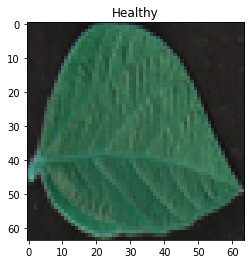

In [ ]:
labels = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

plt.imshow(test_img)
plt.title(labels[prediction[0]])
plt.show()

In [ ]:
pred_labels = svm_rbf.predict(feat_test)

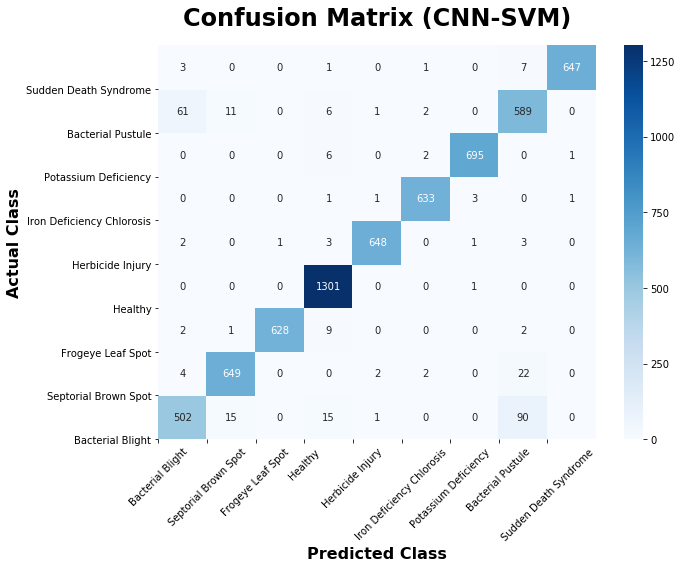

In [ ]:
confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-SVM)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_3.png")
plt.show()

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       623
           1       0.95      0.96      0.96       679
           2       1.00      0.99      0.99       642
           3       0.99      1.00      0.99      1302
           4       0.99      0.99      0.99       658
           5       0.98      0.99      0.99       639
           6       0.99      0.99      0.99       704
           7       0.86      0.85      0.86       670
           8       1.00      0.99      0.99       659

    accuracy                           0.96      6576
   macro avg       0.96      0.96      0.96      6576
weighted avg       0.96      0.96      0.96      6576



In [ ]:
%%time
random_forest_classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", n_jobs=-1)

random_forest_classifier.fit(feat_train_val, np.argmax(y_train_val, axis=1))

print("Fitting done!")

Fitting done!
CPU times: user 15min 51s, sys: 0 ns, total: 15min 51s
Wall time: 8min 2s


In [ ]:
dump(random_forest_classifier, f"./drive/My Drive/Dataset/trained_model_random_forest_classifier_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

['./drive/My Drive/Dataset/trained_model_random_forest_classifier_Sunday-01-19-2020-02-27-59']

In [ ]:
random_forest_classifier.score(feat_train_val, np.argmax(y_train_val, axis=1))

1.0

In [ ]:
random_forest_classifier.score(feat_test, np.argmax(y_test_labels, axis=1))

0.9435827250608273

In [ ]:
random_forest_classifier = load("/content/drive/My Drive/Dataset/trained_model_random_forest_classifier_Sunday-01-19-2020-02-27-59")

In [ ]:
test_img = x_test[3000]

In [ ]:
%%time

prediction = random_forest_classifier.predict(model_new.predict(test_img.reshape((1, 64, 64, 3))).reshape((1, -1)))

CPU times: user 37.4 ms, sys: 0 ns, total: 37.4 ms
Wall time: 113 ms


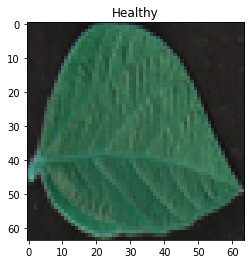

In [ ]:
labels = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

plt.imshow(test_img)
plt.title(labels[prediction[0]])
plt.show()

<BarContainer object of 1152 artists>

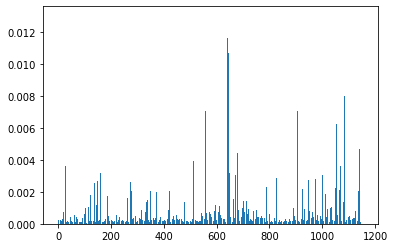

In [ ]:
feat_imp = random_forest_classifier.feature_importances_

plt.bar(range(0, len(feat_imp)), feat_imp)

In [ ]:
pred_labels = random_forest_classifier.predict(feat_test)

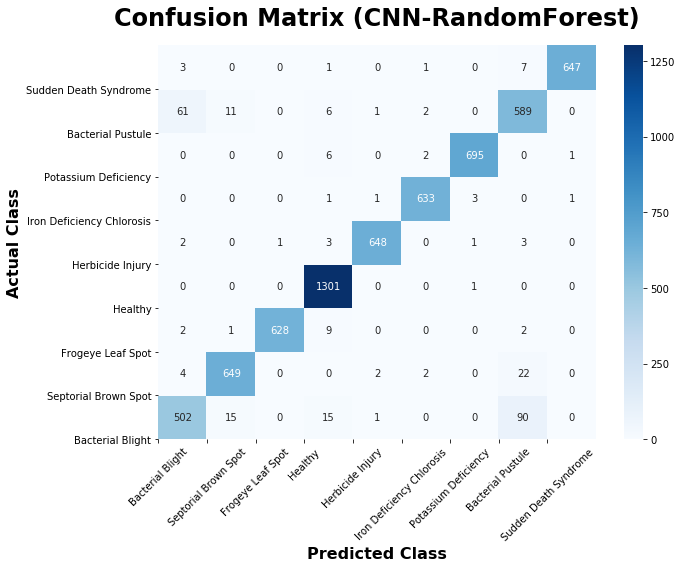

In [ ]:
confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-RandomForest)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_4.png")
plt.show()

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       623
           1       0.93      0.94      0.93       679
           2       0.98      0.98      0.98       642
           3       0.96      1.00      0.98      1302
           4       0.97      0.97      0.97       658
           5       0.98      0.98      0.98       639
           6       0.99      0.98      0.99       704
           7       0.84      0.82      0.83       670
           8       0.99      0.98      0.98       659

    accuracy                           0.94      6576
   macro avg       0.94      0.94      0.94      6576
weighted avg       0.94      0.94      0.94      6576



In [ ]:
%%time
xgb = XGBClassifier(learning_rate=0.01, 
                    n_estimators=300,
                    objective="multi:softmax",
                    num_class=9,
                    n_jobs=-1)

eval_set = [(feat_test, np.argmax(y_test_labels, axis=1))]

xgb.fit(feat_train_val, np.argmax(y_train_val, axis=1), eval_metric="merror", 
        eval_set=eval_set, verbose=True)

print("Fitting done!")

[0]	validation_0-merror:0.238595
[1]	validation_0-merror:0.227798
[2]	validation_0-merror:0.218826
[3]	validation_0-merror:0.215481
[4]	validation_0-merror:0.207725
[5]	validation_0-merror:0.205444
[6]	validation_0-merror:0.199513
[7]	validation_0-merror:0.197841
[8]	validation_0-merror:0.194647
[9]	validation_0-merror:0.191454
[10]	validation_0-merror:0.189477
[11]	validation_0-merror:0.187652
[12]	validation_0-merror:0.184154


KeyboardInterrupt: ignored

In [ ]:
dump(xgb, f"./drive/My Drive/Dataset/xgb_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

In [ ]:
xgb.score(feat_train_val, np.argmax(y_train_val, axis=1))

In [ ]:
xgb.score(feat_test, np.argmax(y_test_labels, axis=1))

In [ ]:
xgb = load("/content/drive/My Drive/Dataset/xgb_Tuesday-08-27-2019-05-48-05")

In [ ]:
all_predictions = []

for i in range(0, 6576, 1):
  test_img = x_test[i]
  prediction = xgb.predict(model_new.predict(test_img.reshape((1, 64, 64, 3))).reshape((1, -1)))
  all_predictions.append(prediction[0])

In [ ]:
category1 = filter(lambda x: x == 9, all_predictions)

In [ ]:
temp = list(category1)

In [ ]:
len(temp)

0

In [ ]:
%%time
prediction = xgb.predict(model_new.predict(test_img.reshape((1, 64, 64, 3))).reshape((1, -1)))

CPU times: user 7 ms, sys: 0 ns, total: 7 ms
Wall time: 7.47 ms


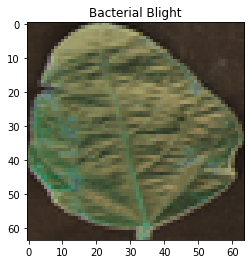

In [ ]:
labels = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

plt.imshow(test_img)
plt.title(labels[prediction[0]])
plt.show()

<BarContainer object of 1152 artists>

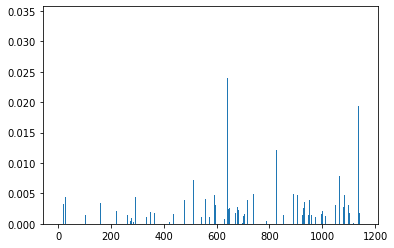

In [ ]:
feat_imp = xgb.feature_importances_

plt.bar(range(0, len(feat_imp)), feat_imp)

In [ ]:
pred_labels = xgb.predict(feat_test)

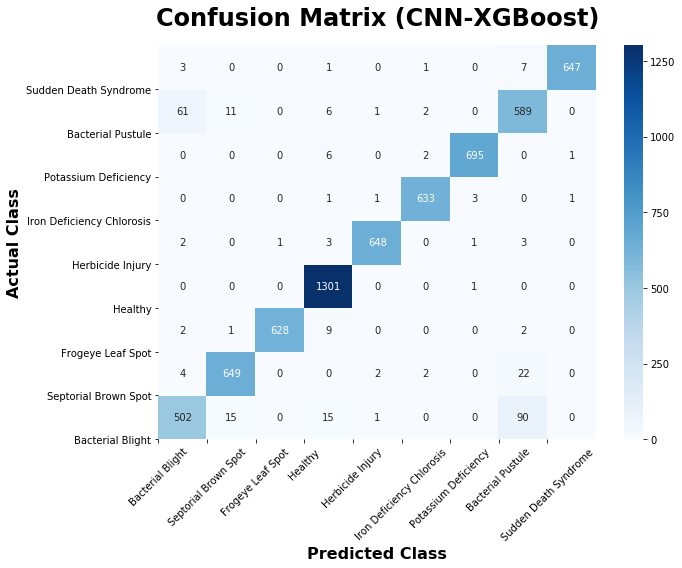

In [ ]:
confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-XGBoost)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_5.png")
plt.show()

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.67      0.68       623
           1       0.86      0.91      0.88       679
           2       0.96      0.91      0.93       642
           3       0.91      0.99      0.95      1302
           4       0.93      0.91      0.92       658
           5       0.94      0.96      0.95       639
           6       0.97      0.92      0.95       704
           7       0.75      0.70      0.72       670
           8       0.96      0.94      0.95       659

    accuracy                           0.89      6576
   macro avg       0.89      0.88      0.88      6576
weighted avg       0.89      0.89      0.89      6576



In [ ]:
sfm = SelectFromModel(xgb, threshold=0.002)
sfm.fit(feat_train_val, np.argmax(y_train_val, axis=1))

KeyboardInterrupt: ignored

In [ ]:
feat_train_val_imp = sfm.transform(feat_train_val)
feat_test_imp = sfm.transform(feat_test)

In [ ]:
%%time
xgb = XGBClassifier(learning_rate=0.01, 
                    n_estimators=300,
                    objective="multi:softmax",
                    num_class=9,
                    n_jobs=-1)

eval_set = [(feat_test_imp, np.argmax(y_test_labels, axis=1))]

xgb.fit(feat_train_val_imp, np.argmax(y_train_val, axis=1), eval_metric="merror", 
        eval_set=eval_set, verbose=True)

print("Fitting done!")